An example illustrating how to use our model to fit to a dataset containing events, times, and TMB values.  When comparing different models test folds should be used.

In [ ]:
import pathlib
path = pathlib.Path.cwd()
if path.stem == 'tmb_survival':
    cwd = path
else:
    cwd = list(path.parents)[::-1][path.parts.index('tmb_survival')]
import sys
sys.path.append(str(cwd))
import pickle
import numpy as np
from model.model import Encoders, NN
from model.layers import Losses
from model import utils
import tensorflow as tf
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib import pyplot as plt
import pickle


Load a data table for TCGA SKCM.

In [3]:
df = pickle.load(open(cwd / 'files' / 'SKCM_data.pkl', 'rb'))

Instantiate a log transformer object

In [4]:
t = utils.LogTransform(bias=4, min_x=0)

Prepare the data.

In [5]:
tmb = t.trf(df.tmb.values)[:, np.newaxis]
times = df['OS.time'].values[:, np.newaxis]
events = df['OS'].values[:, np.newaxis]
cancer_strat = np.zeros_like(df['tmb']) ##no cancer info, if there are multiple cancers can stratify by cancer type
y_label = np.stack(np.concatenate([times, events, cancer_strat[:, np.newaxis]], axis=-1))

Create a tensorflow dataset.

In [ ]:
ds_all = tf.data.Dataset.from_tensor_slices((
                                            (
                                                tmb
                                            ),
                                            (
                                                y_label,
                                            ),
                                            ))

ds_all = ds_all.batch(len(y_label), drop_remainder=False).repeat()

Create a callback to stop training.

In [7]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=30, mode='min', restore_best_weights=True)]

Create our model.  The model allows for a list of encoders for if there are multiple inputs.  We have a single input, TMB, so we only need one encoder.

In [8]:
encoder_1 = Encoders.Encoder(shape=(1,), layers=(128, 128), dropout=.05)
net = NN(encoders=[encoder_1.model], layers=(), norm=True)
net.model.compile(loss=Losses.CoxPH(cancers=1),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Fit the model.

In [ ]:
net.model.fit(ds_all, callbacks=callbacks, epochs=500, steps_per_epoch=10)

Obtain the model risks.

In [ ]:
risks = net.model.predict(ds_all, steps=1)

Plot the risks versus TMB (logged).

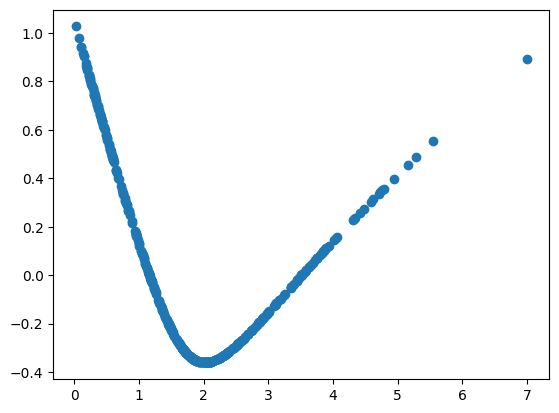

In [11]:
plt.scatter(tmb, risks)

Check the concordance index.

In [12]:
concordance_index(times, -risks, events)

0.6213469796139576

Compare splitting patients by median TMB versus median model risk.

In [13]:
#median TMB p value
low_times = times[:, 0][tmb[:, 0] <= np.median(tmb)]
low_events = events[:, 0][tmb[:, 0] <= np.median(tmb)]
high_times = times[:, 0][tmb[:, 0] > np.median(tmb)]
high_events = events[:, 0][tmb[:, 0] > np.median(tmb)]

print(logrank_test(low_times, high_times, event_observed_A=low_events, event_observed_B=high_events).p_value)



0.035487454365859275


<Axes: xlabel='timeline'>

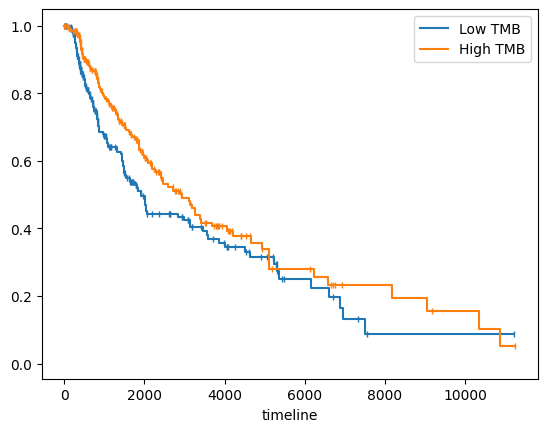

In [14]:
#median TMB kaplan
kmf = KaplanMeierFitter()
kmf.fit(low_times, low_events, label='Low TMB').plot_survival_function(show_censors=True, ci_alpha=0, censor_styles={"marker": "|", "ms":5})
kmf.fit(high_times, high_events, label='High TMB').plot_survival_function(show_censors=True, ci_alpha=0, censor_styles={"marker": "|", "ms":5})

In [15]:
#median model risk p value
low_times = times[:, 0][risks[:, 0] <= np.median(risks)]
low_events = events[:, 0][risks[:, 0] <= np.median(risks)]
high_times = times[:, 0][risks[:, 0] > np.median(risks)]
high_events = events[:, 0][risks[:, 0] > np.median(risks)]

print(logrank_test(low_times, high_times, event_observed_A=low_events, event_observed_B=high_events).p_value)

1.0559362835949314e-07


<Axes: xlabel='timeline'>

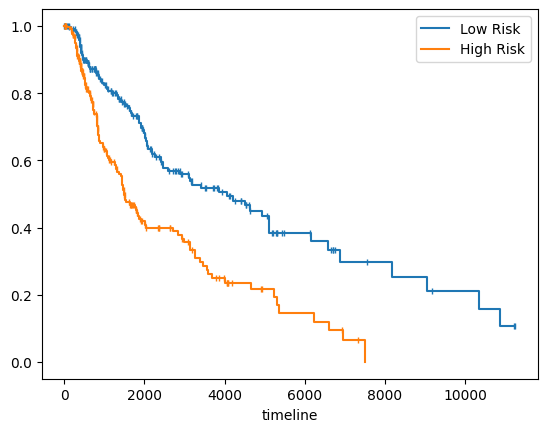

In [16]:
#median model risk kaplan
kmf = KaplanMeierFitter()
kmf.fit(low_times, low_events, label='Low Risk').plot_survival_function(show_censors=True, ci_alpha=0, censor_styles={"marker": "|", "ms":5})
kmf.fit(high_times, high_events, label='High Risk').plot_survival_function(show_censors=True, ci_alpha=0, censor_styles={"marker": "|", "ms":5})